In [1]:
import pandas as pd
from astropy.table import Table
from ctapipe.instrument import SubarrayDescription
from lstchain.io.io import dl1_params_lstcam_key, dl1_images_lstcam_key
from lstchain.io import read_calibration_file
import sys
sys.path.append('/Users/vdk/GeneveWork/Code/calibpipe-main-calibpipe/')
from astropy.io import ascii
import numpy as np
import pandas as pd
import matplotlib
import csv
import scipy
import matplotlib.pyplot as plt
from seaborn import histplot
import random
import copy
from os import path, makedirs
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from ctapipe.containers import MuonEfficiencyContainer
from ctapipe.coordinates import CameraFrame, TelescopeFrame
from ctapipe.io import EventSource, EventSeeker
from ctapipe.core import TelescopeComponent
from ctapipe.core.traits import (
    List,
    Int,
    FloatTelescopeParameter,
    TelescopeParameter,
    Unicode,
)
from ctapipe.image.cleaning import tailcuts_clean
from ctapipe.image.muon import MuonRingFitter, MuonIntensityFitter
from traitlets.config import Config
from ctapipe.image import ImageProcessor
from ctapipe.image.muon import MuonProcessor
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
from ctapipe.calib import CameraCalibrator
from traitlets.config.loader import Config, FileConfigLoader, JSONFileConfigLoader
import pathlib
from calibpipe.throughput import MuonCalibrator
from traitlets.config import Config
from astropy.time import Time
from astropy.coordinates import EarthLocation,SkyCoord, AltAz 
from traitlets.config import Config
import time
from ctapipe.image import number_of_islands
import json
from pyirf import spectral
from lstchain.image.muon import analyze_muon_event, tag_pix_thr





In [2]:


filename = '/Users/vdk/dl1_simtel_corsika_run32.h5'
subarray = SubarrayDescription.from_hdf(filename)

images = Table.read(filename, path=dl1_images_lstcam_key)['image']
parameters = pd.read_hdf(filename, key=dl1_params_lstcam_key)

pd.set_option('display.max_columns', None)
for i in parameters['tel_id'][:]:
    if i != 1:
        print(f"Other telescope = {i}")

In [3]:
parameters

,obs_id,event_id,intensity,log_intensity,x,y,r,phi,length,length_uncertainty,width,width_uncertainty,psi,skewness,kurtosis,time_gradient,intercept,leakage_intensity_width_1,leakage_intensity_width_2,leakage_pixels_width_1,leakage_pixels_width_2,n_pixels,concentration_cog,concentration_core,concentration_pixel,n_islands,alt_tel,az_tel,sin_az_tel,calibration_id,mc_energy,log_mc_energy,mc_alt,mc_az,mc_core_x,mc_core_y,mc_h_first_int,mc_type,mc_az_tel,mc_alt_tel,mc_x_max,mc_core_distance,wl,tel_id,tel_pos_x,tel_pos_y,tel_pos_z,trigger_type,trigger_time,event_type,disp_dx,disp_dy,disp_norm,disp_angle,disp_sign,src_x,src_y
0,32,36408,99.310150,1.996994,-0.684215,0.901547,1.131785,2.219991,0.047784,0.003642,0.042654,0.001438,-0.922998,-0.078967,3.308017,-0.571464,12.007290,0.582020,1.000000,0.001078,0.002156,4,1.000000,0.000000,0.391756,1,1.22173,3.141593,-8.742278e-08,-1,0.029072,-1.536518,1.201188,3.218674,28.006218,-667.028931,37154.308594,101,3.141593,1.22173,182.222229,622.866649,0.892652,1,-70.93,-52.07,43.0,32,1.683124e+09,32,0.137264,-0.122389,0.180424,-0.728172,1.0,-0.546951,0.779158
1,32,52309,311.945170,2.494078,-0.636553,0.681062,0.932226,2.322428,0.314036,0.007815,0.085121,0.003361,0.787292,-0.598319,1.772794,-3.101698,13.160847,0.000000,0.049085,0.000000,0.001078,21,0.075613,0.280655,0.137740,2,1.22173,3.141593,-8.742278e-08,-1,0.144838,-0.839118,1.188657,3.159765,25.598225,21.702986,10368.984375,101,3.141593,1.22173,681.428589,121.491364,0.271054,1,-70.93,-52.07,43.0,32,1.683124e+09,32,-0.287892,-0.491229,0.551193,1.040687,-1.0,-0.924445,0.189833
2,32,142605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,-1,1.22173,3.141593,-8.742278e-08,-1,0.494449,-0.305878,1.335804,3.020257,-1431.811768,329.206421,19405.929688,101,3.141593,1.22173,290.500000,1413.283727,NaN,1,-70.93,-52.07,43.0,32,1.683124e+09,32,NaN,NaN,NaN,NaN,NaN,3.239405,-0.794516
3,32,155806,185.589828,2.268554,-0.506757,-0.123082,0.521490,-2.903324,0.091302,0.004895,0.051648,0.002935,-0.558236,-0.612578,3.133814,-0.582423,12.642365,0.000000,0.000000,0.000000,0.000000,8,0.654466,0.409791,0.219252,1,1.22173,3.141593,-8.742278e-08,-1,1.861871,0.269950,1.221249,3.100619,-493.921906,-131.822906,19126.582031,101,3.141593,1.22173,556.821716,430.444744,0.565683,1,-70.93,-52.07,43.0,32,1.683124e+09,32,0.500839,-0.269724,0.567677,-0.494006,1.0,-0.005919,-0.392807
4,32,158903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,-1,1.22173,3.141593,-8.742278e-08,-1,0.143073,-0.844443,1.261266,2.785216,-329.979462,879.422791,17412.664062,101,3.141593,1.22173,322.000000,966.843028,NaN,1,-70.93,-52.07,43.0,32,1.683124e+09,32,NaN,NaN,NaN,NaN,NaN,1.611188,-2.986234
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353,32,9810705,333.187785,2.522689,0.013398,-0.642204,0.642343,-1.549937,0.386958,0.015063,0.126753,0.004961,-1.426373,-1.337288,3.019425,-4.346836,13.413558,0.000000,0.000000,0.000000,0.000000,22,0.000000,0.345872,0.113401,2,1.22173,3.141593,-8.742278e-08,-1,0.349181,-0.456950,1.229770,3.148904,-172.762085,-218.184860,13297.289062,101,3.141593,1.22173,318.235291,194.843323,0.327562,1,-70.93,-52.07,43.0,32,1.683126e+09,32,0.211949,0.710672,0.672769,1.280957,-1.0,0.225347,0.068468
354,32,9911207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,-1,1.22173,3.141593,-8.742278e-08,-1,0.609458,-0.215056,1.204602,2.955207,-293.181030,426.494415,16551.890625,101,3.141593,1.22173,456.428558,527.654640,NaN,1,-70.93,-52.07,43.0,32,1.683126e+09,32,NaN,NaN,NaN,NaN,NaN,-0.316418,-1.859358
355,32,9915601,97.463614,1.988843,-0.435457,-0.824414,0.932352,-2.056750,0.101864,0.005170,0.059265,0.003950,-1.300985,0.372021,2.004355,-22.340897,12.780290,0.000000,0.000000,0.000000,0.000000,1

### CTApipe Observation Processing


In [4]:
# Треба завантажити конфіг в івент соурс


config_filename = '/Users/vdk/RealLST/typical_run_data/lstchain_standard_v0.10_heuristic_ff.json'

with open(config_filename) as json_file:
    config_data = json.load(json_file)

custom_config = Config(config_data)

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.1"],
                                                        ["ring_completeness", "parameters.completeness > 0.1"]]},
                                    "ImageParameterQuery" :{
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

cfg = Config({
    "source_config": {
        "EventSource" : {
            "allowed_tels": [1],"max_events": 9999}},
        "PointingSource":{
            "drive_report_path": '/Users/vdk/RealLST/data/DrivePosition_log_20231007.txt'},
        "LSTR0Corrections": {
          "calib_scale_high_gain":1.088,
          "calib_scale_low_gain":1.004,
          "drs4_pedestal_path": '/Users/vdk/RealLST/data/drs4_pedestal.Run14937.0000.h5',
          "calibration_path": '/Users/vdk/RealLST/data/calibration_filters_52.Run14938.0000.h5',
          "drs4_time_calibration_path": '/Users/vdk/RealLST/data/time_calibration.Run08349.0000.h5'
      }})

config = replace_config(standard_config, muon_processor_config)
#onfig = replace_config(config, muon_processor_config_2)
config = replace_config(config, custom_config)

image_processor = ImageProcessor(source.subarray)
muon_processor = MuonProcessor(source.subarray, config = Config(config))
calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray, config = Config(config))


NameError: name 'int_cut' is not defined

### CTApipe 4LST processing

In [ ]:
int_cut = 0.2
min_pixel = 70

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.1"],
                                                        ["ring_completeness", "parameters.completeness > 0.1"]]},
                                    "ImageParameterQuery" :{
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]}}})

In [ ]:
event_ids_calib = []
impacts = []
widths = []
for k in range(1,101):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    source = EventSource(filename)
    event_iterator = iter(source)
    for i,event in enumerate(event_iterator):
        for m in event.trigger.tels_with_trigger:
            checker += 1
            image_processor = ImageProcessor(source.subarray)
            muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
            calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
            calib(event)
            image_processor(event)
            muon_processor(event)
            for m in event.muon.tel.keys():
                if not np.isnan(event.muon.tel[m].efficiency.width) and (0.2*11 < event.muon.tel[m].efficiency.impact.to_value() < 0.9*11):
                    event_container[keks+i] = event
                    event_ids_calib.append(event.index.event_id)
                    impacts.append(event.muon.tel[m].efficiency.impact)
                    widths.append(event.muon.tel[m].efficiency.width)
    t2 = time.perf_counter(), time.process_time()
    print("checker = ", checker)   

print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14534


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14659


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14794


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14915


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  15031


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  15153


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  15277


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  15396


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  15533


TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeP

checker =  15677


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  15833


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  15948


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16060


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16192


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16321


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16434


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16560


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16686


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16806


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  16912


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  17049


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  17195


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  17308


TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeP

checker =  17435


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  17544


TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeP

checker =  17665


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  17780


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  17928


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18055


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18188


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18308


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18448


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18607


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18738


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18853


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  18965


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  19107


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  19256


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  19384


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  19501


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  19654


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  19771


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  19907


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20040


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20161


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20290


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20412


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20553


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20670


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20812


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  20957


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21086


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21228


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21351


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21503


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21629


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21742


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21859


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  21985


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  22126


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  22260


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  22386


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  22507


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  22632


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  22764


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  22897


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23015


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23136


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23261


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23394


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23522


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23651


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23786


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  23931


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24053


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24180


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24297


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24428


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24549


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24683


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24811


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  24926


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25050


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25186


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25309


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25434


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25581


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25724


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25857


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  25982


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  26113


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  26229


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  26355


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  26498


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  26640


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  26768


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  26889


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  27027


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  27168


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  27287
 Real time: 45804.08 seconds
 CPU time: 3170.50 seconds


In [ ]:
print("muons = ", len(event_container))
print("muons events = ", event_container.keys())

opt_eff_m = []
for i in event_container:
    for m in event_container[i].trigger.tels_with_trigger:
        if not np.isnan(event_container[i].muon.tel[m].efficiency.optical_efficiency):
            opt_eff_m.append(event_container[i].muon.tel[m].efficiency.optical_efficiency)

print("mean = ", np.mean(opt_eff_m))
print("std = ", np.std(opt_eff_m))
print("len = ", len(opt_eff_m))
print(f"event_ids = {event_ids_calib}")


muons =  114
muons events =  dict_keys([1036, 1056, 1114, 1102, 1003, 1012, 1052, 1072, 1098, 1032, 1035, 1051, 1080, 1007, 1031, 1059, 1065, 1100, 1094, 1055, 1033, 1067, 1099, 1006, 1073, 1086, 1097, 1087, 1128, 1057, 1083, 1132, 1147, 1041, 1109, 1121, 1017, 1028, 1048, 1029, 1040, 1103, 1093, 1018, 1024, 1069, 1104, 1050, 1071, 1112, 1009, 1030, 1049, 1008, 1062, 1060, 1066, 1090, 1096, 1116, 1091, 1054, 1078, 1113, 1122, 1139, 1133, 1136, 1076, 1125, 1088, 1027, 1053, 1044, 1013, 1117, 1015, 1045, 1110, 1020, 1061, 1082, 1107, 1127, 1046, 1101, 1034, 1043, 1085, 1135, 1038, 1001, 1019, 1126, 1129, 1075, 1077, 1070, 1120, 1058, 1037, 1092, 1074, 1025, 1026, 1089, 1004, 1039, 1064, 1106, 1068, 1131, 1095, 1063])
mean =  0.22027917682529152
std =  0.017234775579283247
len =  114
event_ids = [48900, 213300, 926200, 1154900, 1574900, 485800, 535600, 732600, 1274200, 86500, 327900, 738300, 835500, 1394500, 1639100, 871000, 615300, 1128200, 1661400, 212300, 1225500, 1519900, 1975900, 729

Text(0.5, 1.0, 'Widths of muons processed by CalibPipe method')

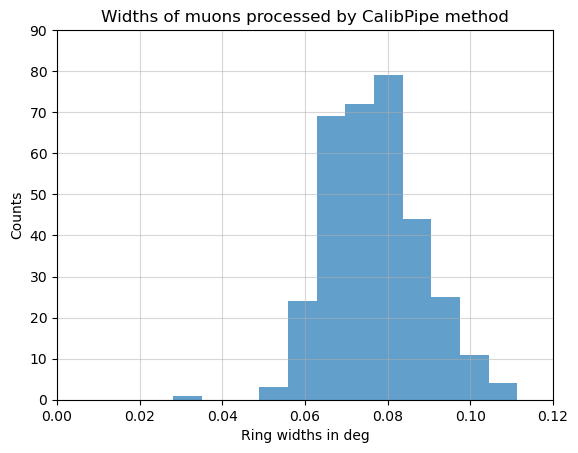

In [ ]:
plt.hist(widths, bins = 12, alpha = 0.7)
plt.ylabel('Counts')
plt.xlabel('Ring widths in deg')
plt.xlim(0,0.12)
plt.ylim(0,90)
plt.grid(alpha = 0.5)
plt.title("Widths of muons processed by CalibPipe method")

Text(0.5, 1.0, 'Impact of muons processed by CalibPipe method')

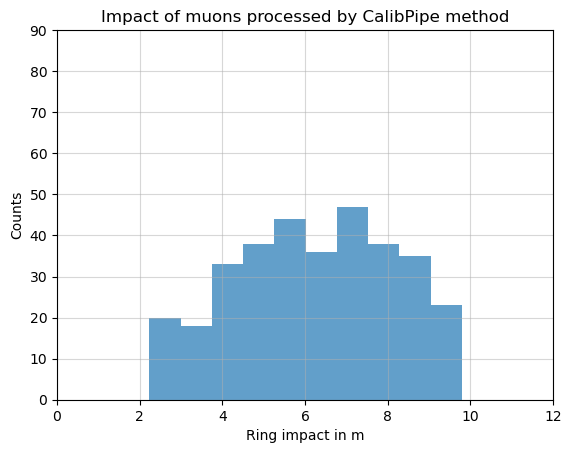

In [ ]:
plt.hist(impacts, bins = 10, alpha = 0.7)
plt.ylabel('Counts')
plt.xlabel('Ring impact in m')
plt.xlim(0,12)
plt.ylim(0,90)
plt.grid(alpha = 0.5)
plt.title("Impact of muons processed by CalibPipe method")

### lstchain processing

In [7]:


int_cut = 0.3
min_pixel = 70

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.1"],
                                                        ["ring_completeness", "parameters.completeness > 0.1"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})

checker = 0
event_container = {}

muon_params = []
event_ids_lstchain = []

for k in range(1,101):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    print(filename)
    source = EventSource(filename)
    event_iterator = iter(source)

    for i,event in enumerate(event_iterator):
        for m in event.trigger.tels_with_trigger:
            checker += 1
            image_processor = ImageProcessor(source.subarray)
            muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
            #muon_processor = MuonProcessor(source.subarray)
            calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
            #print(f"Non Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
            calib(event)
            #image_processor(event)
            #muon_processor(event)
            event_id = event.index.event_id
            for tel_id in event.trigger.tels_with_trigger:
                image = event.dl1.tel[tel_id].image
                if not tag_pix_thr(event.dl1.tel[tel_id].image):  # default skips pedestal and calibration events
                    continue

                (
                    muonintensityparam, dist_mask, size, size_outside_ring,
                    muonringparam, good_ring, radial_distribution,
                    mean_pixel_charge_around_ring, muonparameters
                ) = analyze_muon_event(source.subarray, tel_id, event_id,
                                    image, good_ring_config=None,
                                    plot_rings=False, plots_path=False
                                    )
                if good_ring:
                    muon_params.append(muonintensityparam)
                    event_ids_lstchain.append(event.index.event_id)


/Users/vdk/LST/4LSTmuons/simtel_run101_muon.simtel.gz
fit iteration 0 shows next params radius 0.8476850962415643 deg center fov_lon -1.005008698989278 deg center fov_lat -0.11802161550646104 deg
fit iteration 1 shows next params radius 0.8476850962415643 deg center fov_lon -1.005008698989278 deg center fov_lat -0.11802161550646104 deg
RING SIZE 1421.0389404296875
fit iteration 0 shows next params radius 1.1810631561639862 deg center fov_lon -0.7509374960628581 deg center fov_lat 0.23936877787412406 deg
fit iteration 1 shows next params radius 1.1810631561639862 deg center fov_lon -0.7509374960628581 deg center fov_lat 0.23936877787412406 deg
event_id 48900 has center_fov_lon = -0.7509374960628581 deg and center_fov_lon = 0.23936877787412406 deg, radius = 1.1810631561639862 deg
OPTICAL EFFICIENCY 0.21227167361652644
RING SIZE 2627.5810546875
Impact parameter=7.053 m, ring_width=0.043 deg, ring radius=1.181 deg, ring completeness=0.833
fit iteration 0 shows next params radius 0.95326304

KeyboardInterrupt: 

In [12]:
event.pointing.tel[1]

ctapipe.containers.TelescopePointingContainer:
                       azimuth: Azimuth, measured N->E with default nan rad
                                [rad]
                      altitude: Altitude with default nan rad [rad]

In [ ]:
opt_eff = []
for muon_container in muon_params:
    opt_eff.append(muon_container.optical_efficiency)
    #print(muon_container.optical_efficiency)

In [ ]:
print(f"mean = {np.mean(opt_eff)}")
print(f"len =  {len(opt_eff)}")

mean = 0.1845634788256835
len =  385


In [ ]:
source.subarray.tels[1].camera.geometry

CameraGeometry(name='LSTCam', pix_type=PixelShape.HEXAGON, npix=1855, cam_rot=0.000 deg, pix_rot=40.893 deg, frame=<CameraFrame Frame (focal_length=29.30565071105957 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>)

In [ ]:
widths = []
impacts = []
for muon_container in muon_params:
    widths.append(muon_container.width)
    impacts.append(muon_container.impact)

Text(0.5, 1.0, 'Widths of muons processed by lstchain method')

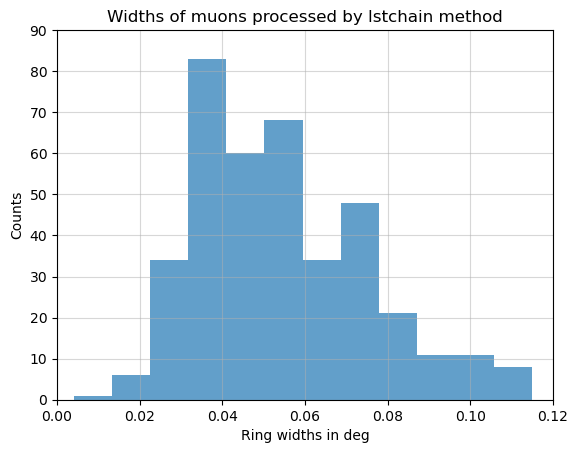

In [ ]:
plt.hist(widths, bins = 12, alpha = 0.7)
plt.ylabel('Counts')
plt.xlabel('Ring widths in deg')
plt.xlim(0,0.12)
plt.ylim(0,90)
plt.grid(alpha = 0.5)
plt.title("Widths of muons processed by lstchain method")

Text(0.5, 1.0, 'Impact of muons processed by lstchain method')

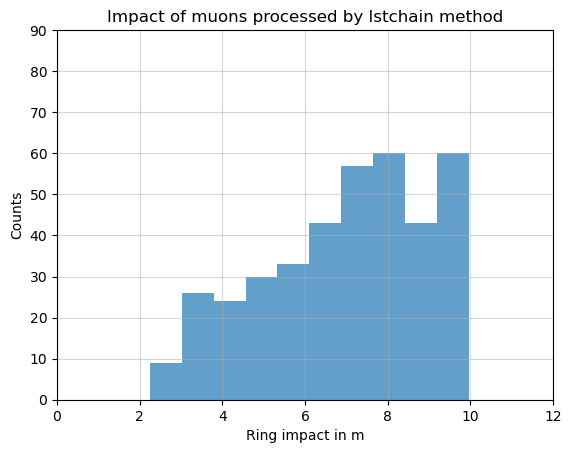

In [ ]:
plt.hist(impacts, bins = 10, alpha = 0.7)
plt.ylabel('Counts')
plt.xlabel('Ring impact in m')
plt.xlim(0,12)
plt.ylim(0,90)
plt.grid(alpha = 0.5)
plt.title("Impact of muons processed by lstchain method")

In [ ]:
muon_params

[ctapipe.containers.MuonEfficiencyContainer:
                          width: width of the muon ring in degrees with default
                                 nan deg
                         impact: distance of muon impact position from center of
                                 mirror with default nan m
                       impact_x: impact parameter x position with default nan m
                       impact_y: impact parameter y position with default nan m
             optical_efficiency: optical efficiency muon with default nan,
 ctapipe.containers.MuonEfficiencyContainer:
                          width: width of the muon ring in degrees with default
                                 nan deg
                         impact: distance of muon impact position from center of
                                 mirror with default nan m
                       impact_x: impact parameter x position with default nan m
                       impact_y: impact parameter y position with default

### Modified ctapipe

In [ ]:
int_cut = 0.1
min_pixel = 50

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.3"],
                                                        ["ring_completeness", "parameters.completeness > 0.3"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})

In [ ]:
from ctapipe.core.traits import Bool, BoolTelescopeParameter, ComponentName
from ctapipe.image.cleaning import ImageCleaner


#event_ids_calib = []
impacts = []
widths = []

image_cleaner_type = ComponentName(
        ImageCleaner, default_value="TailcutsImageCleaner"
    )
for k in range(1,11):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    source = EventSource(filename)
    event_iterator = iter(source)
    geom = source.subarray.tels[1].camera.geometry
    for i,event in enumerate(event_iterator):
        for m in event.trigger.tels_with_trigger:
            #checker += 1
            image_processor = ImageProcessor(source.subarray)
            muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)

            #clean = ImageCleaner.from_name(image_cleaner_type, subarray=source.subarray)

            #calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
            calib = CameraCalibrator(image_extractor_type="LocalPeakWindowSum",subarray = source.subarray)
            calib(event)
            image_processor(event)
            
            #for tel_id, dl1_camera in event.dl1.tel.items():
            #        dl1_camera.image_mask = tailcuts_clean(geom, image,picture_thresh=10,boundary_thresh=5)
                #dl1_camera.image_mask = self.clean(tel_id=tel_id,image=dl1_camera.image,arrival_times=dl1_camera.peak_time)
            
            muon_processor(event)
            for m in event.muon.tel.keys():
                if not np.isnan(event.muon.tel[m].efficiency.width) and (0.2*11 < event.muon.tel[m].efficiency.impact.to_value() < 0.9*11):
                    event_container[keks+i] = event
                    #event_ids_calib.append(event.index.event_id)
                    impacts.append(event.muon.tel[m].efficiency.impact)
                    widths.append(event.muon.tel[m].efficiency.width)
    t2 = time.perf_counter(), time.process_time()
    print("checker = ", checker)   

print(f" Real time: {t2[0] - t1[0]:.2f} seconds")
print(f" CPU time: {t2[1] - t1[1]:.2f} seconds")


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeP

checker =  14402
 Real time: 44723.54 seconds
 CPU time: 2561.80 seconds


In [ ]:
opt_eff_m = []
for i in event_container:
    for m in event_container[i].trigger.tels_with_trigger:
        if not np.isnan(event_container[i].muon.tel[m].efficiency.optical_efficiency):
            opt_eff_m.append(event_container[i].muon.tel[m].efficiency.optical_efficiency)

print("mean = ", np.mean(opt_eff_m))
print("std = ", np.std(opt_eff_m))
print("len = ", len(opt_eff_m))
print(f"event_ids = {event_ids_calib}")

mean =  4.165306197652354
std =  7.049346709030245
len =  4
event_ids = []


### Event id processing

In [ ]:
event_ids_calib

[]

In [23]:
common_events = []
for event_id in event_ids_calib:
    if event_id in event_ids_lstchain:
        common_events.append(event_id)


In [ ]:
checker = 0

lstchain_container = {}

for k in range(1,41):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    print(filename)
    source = EventSource(filename)
    event_iterator = iter(source)

    for i,event in enumerate(event_iterator):
        if event.index.event_id in common_events:
            for m in event.trigger.tels_with_trigger:
    
                muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
                calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
                
                calib(event)
                event_id = event.index.event_id
                for tel_id in event.trigger.tels_with_trigger:
                    image = event.dl1.tel[tel_id].image
                    if not tag_pix_thr(event.dl1.tel[tel_id].image):  # default skips pedestal and calibration events
                        continue

                    (
                        muonintensityparam, dist_mask, size, size_outside_ring,
                        muonringparam, good_ring, radial_distribution,
                        mean_pixel_charge_around_ring, muonparameters
                    ) = analyze_muon_event(source.subarray, tel_id, event_id,
                                        image, good_ring_config=None,
                                        plot_rings=False, plots_path=False
                                        )
            event.muon.tel[m].efficiency = muonintensityparam
            if checker < 10:
                lstchain_container[event.index.event_id] = event
                checker += 1 
            if checker == 10:
                break
                    

TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run101_muon.simtel.gz
Impact parameter=7.043 m, ring_width=0.044 deg, ring radius=1.233 deg, ring completeness=0.800


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=3.932 m, ring_width=0.054 deg, ring radius=0.995 deg, ring completeness=0.700


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=3.711 m, ring_width=0.032 deg, ring radius=1.177 deg, ring completeness=0.767
Impact parameter=8.096 m, ring_width=0.036 deg, ring radius=1.247 deg, ring completeness=0.600
/Users/vdk/LST/4LSTmuons/simtel_run201_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=5.568 m, ring_width=0.061 deg, ring radius=0.949 deg, ring completeness=0.900
Impact parameter=7.637 m, ring_width=0.058 deg, ring radius=1.221 deg, ring completeness=0.800


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=4.767 m, ring_width=0.031 deg, ring radius=1.220 deg, ring completeness=0.900


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run301_muon.simtel.gz
Impact parameter=6.660 m, ring_width=0.034 deg, ring radius=1.234 deg, ring completeness=0.767
/Users/vdk/LST/4LSTmuons/simtel_run401_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=6.184 m, ring_width=0.061 deg, ring radius=1.181 deg, ring completeness=0.900
/Users/vdk/LST/4LSTmuons/simtel_run501_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=3.736 m, ring_width=0.029 deg, ring radius=1.222 deg, ring completeness=0.567
/Users/vdk/LST/4LSTmuons/simtel_run601_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=4.276 m, ring_width=0.028 deg, ring radius=1.227 deg, ring completeness=0.700
/Users/vdk/LST/4LSTmuons/simtel_run701_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run801_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run901_muon.simtel.gz
/Users/vdk/LST/4LSTmuons/simtel_run1001_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=4.943 m, ring_width=0.024 deg, ring radius=1.201 deg, ring completeness=0.600
/Users/vdk/LST/4LSTmuons/simtel_run1101_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=6.531 m, ring_width=0.069 deg, ring radius=1.019 deg, ring completeness=0.767
/Users/vdk/LST/4LSTmuons/simtel_run1201_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run1301_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=9.701 m, ring_width=0.055 deg, ring radius=1.212 deg, ring completeness=0.500
/Users/vdk/LST/4LSTmuons/simtel_run1401_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=9.414 m, ring_width=0.069 deg, ring radius=1.169 deg, ring completeness=0.567
/Users/vdk/LST/4LSTmuons/simtel_run1501_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run1601_muon.simtel.gz
/Users/vdk/LST/4LSTmuons/simtel_run1701_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run1801_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=3.052 m, ring_width=0.062 deg, ring radius=1.139 deg, ring completeness=0.967
/Users/vdk/LST/4LSTmuons/simtel_run1901_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run2001_muon.simtel.gz
Impact parameter=3.522 m, ring_width=0.036 deg, ring radius=0.991 deg, ring completeness=0.800
/Users/vdk/LST/4LSTmuons/simtel_run2101_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=9.562 m, ring_width=0.058 deg, ring radius=1.211 deg, ring completeness=0.500
/Users/vdk/LST/4LSTmuons/simtel_run2201_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=4.406 m, ring_width=0.042 deg, ring radius=1.151 deg, ring completeness=0.867
/Users/vdk/LST/4LSTmuons/simtel_run2301_muon.simtel.gz
Impact parameter=7.040 m, ring_width=0.051 deg, ring radius=1.213 deg, ring completeness=0.933
/Users/vdk/LST/4LSTmuons/simtel_run2401_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=6.525 m, ring_width=0.030 deg, ring radius=1.223 deg, ring completeness=0.600
/Users/vdk/LST/4LSTmuons/simtel_run2501_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=6.994 m, ring_width=0.051 deg, ring radius=1.192 deg, ring completeness=0.833
/Users/vdk/LST/4LSTmuons/simtel_run2601_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=5.489 m, ring_width=0.038 deg, ring radius=1.208 deg, ring completeness=0.767
/Users/vdk/LST/4LSTmuons/simtel_run2701_muon.simtel.gz
Impact parameter=8.650 m, ring_width=0.059 deg, ring radius=1.174 deg, ring completeness=0.567
/Users/vdk/LST/4LSTmuons/simtel_run2801_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=6.522 m, ring_width=0.055 deg, ring radius=1.197 deg, ring completeness=0.833
/Users/vdk/LST/4LSTmuons/simtel_run2901_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run3001_muon.simtel.gz
Impact parameter=5.712 m, ring_width=0.047 deg, ring radius=1.147 deg, ring completeness=0.767
/Users/vdk/LST/4LSTmuons/simtel_run3101_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run3201_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=7.419 m, ring_width=0.041 deg, ring radius=1.230 deg, ring completeness=0.700
/Users/vdk/LST/4LSTmuons/simtel_run3301_muon.simtel.gz
/Users/vdk/LST/4LSTmuons/simtel_run3401_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=4.519 m, ring_width=0.035 deg, ring radius=1.152 deg, ring completeness=0.933
/Users/vdk/LST/4LSTmuons/simtel_run3501_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=6.337 m, ring_width=0.024 deg, ring radius=1.206 deg, ring completeness=0.533
/Users/vdk/LST/4LSTmuons/simtel_run3601_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run3701_muon.simtel.gz
/Users/vdk/LST/4LSTmuons/simtel_run3801_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types
TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


/Users/vdk/LST/4LSTmuons/simtel_run3901_muon.simtel.gz


TelescopeParameter type argument 'MST_*' did not match any known telescope types
TelescopeParameter type argument 'SST_1M_*' did not match any known telescope types


Impact parameter=8.506 m, ring_width=0.045 deg, ring radius=1.176 deg, ring completeness=0.567
/Users/vdk/LST/4LSTmuons/simtel_run4001_muon.simtel.gz
Impact parameter=5.277 m, ring_width=0.033 deg, ring radius=1.225 deg, ring completeness=0.767


In [25]:
calib_container = {}
checker = 0
for k in range(1,2):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    source = EventSource(filename)
    event_iterator = iter(source)
    for i,event in enumerate(event_iterator):
        if event.index.event_id in common_events: 
            for m in event.trigger.tels_with_trigger:
                image_processor = ImageProcessor(source.subarray)
                muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
                calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
                calib(event)
                #image_processor(event)
                muon_processor(event)

                if checker < 10:
                    calib_container[event.index.event_id] = event
                    checker += 1 
                if checker == 10:
                    break



In [26]:
plot_stop = 0
for key in calib_container:
    for tels in calib_container[key].muon.tel.keys():
            plt.figure(figsize = (6,4))
            camgeom = source.subarray.tel[tels].camera.geometry
            title = f"event_id = {lstchain_container[key].index.event_id}, optical efficiency {round(calib_container[key].muon.tel[tels].efficiency.optical_efficiency,3)}"
            disp = CameraDisplay(camgeom,title=title)
            #disp.image = calib_container[key].simulation.tel[tels].true_image
            #disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
            #print(np.shape(calib_container[key].dl1.tel[m].image))
            disp.image = calib_container[key].dl1.tel[tels].image
            disp.cmap = plt.cm.RdBu_r
            disp.add_colorbar()
            disp.set_limits_percent(95)
            plt.show()
            #plt.savefig(f"/Users/vdk/3978-4000runs_MuonsCleaning+Island17bin_intensitycut<0.3_event{i}.png")
    plot_stop += 1
    if plot_stop >2:
        break
    

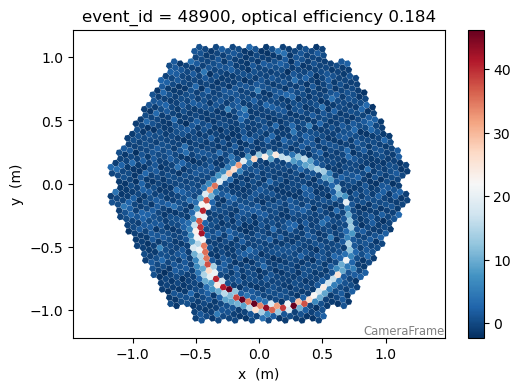

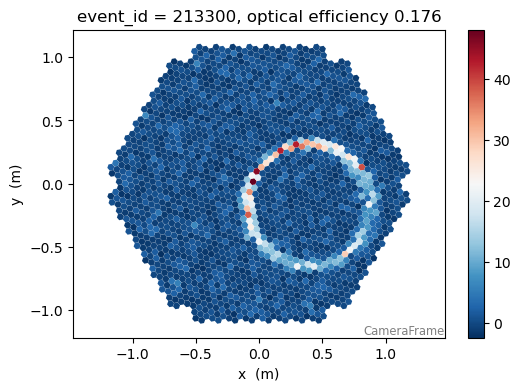

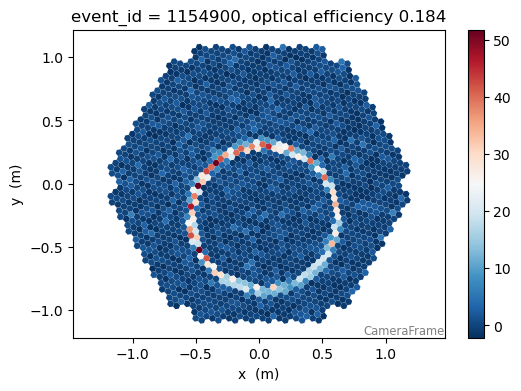

In [ ]:
plot_stop = 0
for key in lstchain_container:
    for tels in lstchain_container[key].trigger.tels_with_trigger:
            plt.figure(figsize = (6,4))
            camgeom = source.subarray.tel[tels].camera.geometry
            title = f"event_id = {lstchain_container[key].index.event_id}, optical efficiency {round(lstchain_container[key].muon.tel[tels].efficiency.optical_efficiency,3)}"
            disp = CameraDisplay(camgeom,title=title)
            #disp.image = lstchain_container[key].simulation.tel[tels].true_image
            #disp.image = event_container[i].r1.tel[m].waveform.sum(axis=1)
            disp.image = lstchain_container[key].dl1.tel[tels].image
            disp.cmap = plt.cm.RdBu_r
            disp.add_colorbar()
            disp.set_limits_percent(95)
            plt.show()
            #plt.savefig(f"/Users/vdk/3978-4000runs_MuonsCleaning+Island17bin_intensitycut<0.3_event{i}.png")
    plot_stop += 1
    if plot_stop > 2: 
        break

In [ ]:
print(lstchain_container[48900].dl1.tel[2])

{'image': array([-1.0669492 , -0.21394937,  0.2282674 , ...,  1.038811  ,
        1.111288  , -0.72970444], dtype=float32),
 'image_mask': None,
 'is_valid': True,
 'parameters': None,
 'peak_time': array([ 9.355646, 11.954134, 11.15245 , ..., 12.011845, 10.367731,
       14.783775], dtype=float32)}


In [ ]:
print(calib_container[48900].dl1.tel[2].image)

[-1.0669492  -0.21394937  0.2282674  ...  1.038811    1.111288
 -0.72970444]


In [32]:
len(event.trigger.tels_with_trigger)

1

#### Check dl1 images and peak time for different methods

In [ ]:
#event_id = 213300
event_id = 48900
tel = calib_container[event_id].trigger.tels_with_trigger[0]
np.count_nonzero(calib_container[event_id].dl1.tel[tel].image == lstchain_container[event_id].dl1.tel[tel].image)

1855

In [ ]:
np.count_nonzero(calib_container[event_id].dl1.tel[tel].peak_time == lstchain_container[event_id].dl1.tel[tel].peak_time)

1855

In [ ]:
print(lstchain_container[event_id].muon.tel[tel])

{'efficiency': {'impact': <Quantity 7.04264073 m>,
                'impact_x': <Quantity -4.18725393 m>,
                'impact_y': <Quantity 5.66265777 m>,
                'optical_efficiency': 0.18430631093081118,
                'width': <Quantity 0.0442029 deg>},
 'parameters': {'completeness': nan,
                'containment': nan,
                'intensity_ratio': nan,
                'mean_squared_error': <Quantity nan deg2>},
 'ring': {'center_distance': <Quantity nan deg>,
          'center_fov_lat': <Quantity nan deg>,
          'center_fov_lon': <Quantity nan deg>,
          'center_phi': <Quantity nan deg>,
          'radius': <Quantity nan deg>}}


In [ ]:
print(calib_container[event_id].muon.tel[tel])

{'efficiency': {'impact': <Quantity 6.98210974 m>,
                'impact_x': <Quantity -5.09130451 m>,
                'impact_y': <Quantity 4.77791531 m>,
                'optical_efficiency': 0.23057685485141466,
                'width': <Quantity 0.07592025 deg>},
 'parameters': {'completeness': 0.8666666666666667,
                'containment': 1.0,
                'intensity_ratio': 0.85448253,
                'mean_squared_error': <Quantity 0.00223588 deg2>},
 'ring': {'center_distance': <Quantity 0.78158689 deg>,
          'center_fov_lat': <Quantity 0.23773275 deg>,
          'center_fov_lon': <Quantity -0.74455437 deg>,
          'center_phi': <Quantity 2.83252904 rad>,
          'radius': <Quantity 1.18849502 deg>}}


In [35]:
event

ctapipe.containers.ArrayEventContainer:
                       index.*: event indexing information with default None
                          r0.*: Raw Data with default None
                          r1.*: R1 Calibrated Data with default None
                         dl0.*: DL0 Data Volume Reduced Data with default None
                         dl1.*: DL1 Calibrated image with default None
                         dl2.*: DL2 reconstruction info with default None
                  simulation.*: Simulated Event Information with default None
                                with type <class
                                'ctapipe.containers.SimulatedEventContainer'>
                     trigger.*: central trigger information with default None
                         count: number of events processed with default 0
                    pointing.*: Array and telescope pointing positions with
                                default None
                 calibration.*: Container for calibra

### Check intensity fitter parameters

In [2]:


int_cut = 0.3
min_pixel = 70

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.1"],
                                                        ["ring_completeness", "parameters.completeness > 0.1"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})

checker = 0
event_container = {}

muon_params = []
event_ids_lstchain = []

for k in range(1,2):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    print(filename)
    source = EventSource(filename)
    event_iterator = iter(source)

    for i,event in enumerate(event_iterator):
        if event.index.event_id in [48900, 213300, 1154900]:
            checker += 1
            for m in event.trigger.tels_with_trigger:
                checker += 1
                image_processor = ImageProcessor(source.subarray)
                muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
                #muon_processor = MuonProcessor(source.subarray)
                calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
                #print(f"Non Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
                calib(event)
                #image_processor(event)
                #muon_processor(event)
                event_id = event.index.event_id
                for tel_id in event.trigger.tels_with_trigger:
                    image = event.dl1.tel[tel_id].image
                    if not tag_pix_thr(event.dl1.tel[tel_id].image):  # default skips pedestal and calibration events
                        continue

                    (
                        muonintensityparam, dist_mask, size, size_outside_ring,
                        muonringparam, good_ring, radial_distribution,
                        mean_pixel_charge_around_ring, muonparameters
                    ) = analyze_muon_event(source.subarray, tel_id, event_id,
                                        image, good_ring_config=None,
                                        plot_rings=False, plots_path=False
                                        )
                    if good_ring:
                        muon_params.append(muonintensityparam)
                        event_ids_lstchain.append(event.index.event_id)
                    break


/Users/vdk/LST/4LSTmuons/simtel_run101_muon.simtel.gz
fit iteration 0 shows next params radius 1.1810631561639862 deg center fov_lon -0.7509374960628581 deg center fov_lat 0.23936877787412406 deg
fit iteration 1 shows next params radius 1.1810631561639862 deg center fov_lon -0.7509374960628581 deg center fov_lat 0.23936877787412406 deg
event_id 48900 has center_fov_lon = -0.7509374960628581 deg and center_fov_lon = 0.23936877787412406 deg, radius = 1.1810631561639862 deg
OPTICAL EFFICIENCY 0.21227167361652644
RING SIZE 2627.5810546875
Impact parameter=7.053 m, ring_width=0.043 deg, ring radius=1.181 deg, ring completeness=0.833
fit iteration 0 shows next params radius 0.9532630467518987 deg center fov_lon -0.32860348695382774 deg center fov_lat 0.7733744538655343 deg
fit iteration 1 shows next params radius 0.9532630467518987 deg center fov_lon -0.32860348695382774 deg center fov_lat 0.7733744538655343 deg
event_id 213300 has center_fov_lon = -0.32860348695382774 deg and center_fov_lon

In [ ]:
print(muon_params[2])

{'impact': <Quantity 3.71090407 m>,
 'impact_x': <Quantity 2.23232918 m>,
 'impact_y': <Quantity 2.96437438 m>,
 'optical_efficiency': 0.18393590256807713,
 'width': <Quantity 0.03223589 deg>}


In [3]:
int_cut = 1
min_pixel = 50

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.1"],
                                                        ["ring_completeness", "parameters.completeness > 0.1"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})


event_ids_calib = []
impacts = []
widths = []
for k in range(1,2):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    source = EventSource(filename)
    event_iterator = iter(source)
    for i,event in enumerate(event_iterator):
        if event.index.event_id in [48900, 213300, 1154900]:
            for m in event.trigger.tels_with_trigger:
                
                image_processor = ImageProcessor(source.subarray)
                muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
                calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
                calib(event)
                image_processor(event)
                muon_processor(event)



event_id 48900 has center_fov_lon = -0.7445543723786515 deg and center_fov_lon = 0.23773274748477383 deg, radius = 1.188495021310819 deg
Muon parameters = {'impact': <Quantity 7.10442735 m>,
 'impact_x': <Quantity -4.32214863 m>,
 'impact_y': <Quantity 5.63843234 m>,
 'optical_efficiency': 0.21501509579369316,
 'width': <Quantity 0.04373853 deg>}
RING SIZE with lstchain mask 2636.4912109375
RING SIZE ORIGINAL 2634.87353515625
event_id 213300 has center_fov_lon = -0.33693657424388546 deg and center_fov_lon = 0.7716381587786871 deg, radius = 0.953637015524016 deg
Muon parameters = {'impact': <Quantity 3.93333555 m>,
 'impact_x': <Quantity 3.38783292 m>,
 'impact_y': <Quantity 1.99842854 m>,
 'optical_efficiency': 0.2034496864990578,
 'width': <Quantity 0.05221377 deg>}
RING SIZE with lstchain mask 2250.62353515625
RING SIZE ORIGINAL 2234.850341796875
event_id 1154900 has center_fov_lon = -0.5121815500036457 deg and center_fov_lon = 0.06804275815096862 deg, radius = 1.1293365236962967 deg

In [ ]:
telescope_description = source.subarray.tel[1]

In [ ]:
telescope_description.optics
optics = telescope_description.optics
mirror_area = optics.mirror_area.to_value(u.m**2)
mirror_radius = np.sqrt(mirror_area / np.pi)

focal_length = optics.equivalent_focal_length

In [ ]:
cam = telescope_description.camera.geometry
camera_frame = CameraFrame(focal_length=focal_length, rotation=cam.cam_rotation)
cam_coords = SkyCoord(x=cam.pix_x, y=cam.pix_y, frame=camera_frame)
tel_coords = cam_coords.transform_to(TelescopeFrame())

In [ ]:
pixel_diameter = 2 * (np.sqrt(cam.pix_area[0] / np.pi) / focal_length * u.rad).to_value(u.rad)

pixel_diameter


0.0018376314424983517

### Look into image and mask

In [ ]:
np.set_printoptions(threshold=sys.maxsize)
ctapipe_1154900_mask = np.loadtxt('/Users/vdk/ctapipe_1154900_mask.txt')
ctapipe_1154900_image = np.loadtxt('/Users/vdk/ctapipe_1154900_image.txt')
lstchain_1154900_mask = np.loadtxt('/Users/vdk/lstchain_1154900_mask.txt')
lstchain_1154900_image = np.loadtxt('/Users/vdk/lstchain_1154900_image.txt')

ctapipe_213300_mask = np.loadtxt('/Users/vdk/ctapipe_213300_mask.txt')
ctapipe_213300_image = np.loadtxt('/Users/vdk/ctapipe_213300_image.txt')
lstchain_213300_mask = np.loadtxt('/Users/vdk/lstchain_213300_mask.txt')
lstchain_213300_image = np.loadtxt('/Users/vdk/lstchain_213300_image.txt')

In [ ]:
for i,j in enumerate(ctapipe_213300_image):
    #if j != lstchain_213300_image[i]:
    if i in [42,188,1600]:
        print(f"ctapipe = {j} -------- lstchain = {lstchain_213300_image[i]}")

ctapipe = -0.7318346500396729 -------- lstchain = -0.7318346500396729
ctapipe = -0.9808492064476013 -------- lstchain = -0.9808492064476013
ctapipe = -1.6900439262390137 -------- lstchain = -1.6900439262390137


In [ ]:
counter = 0
for i,j in enumerate(ctapipe_213300_mask):
    if j != lstchain_213300_mask[i]:
        counter += 1
        print(f"ctapipe = {j} -------- lstchain = {lstchain_213300_mask[i]} for the {i}th pixel")

ctapipe = 0.0 -------- lstchain = 1.0 for the 42th pixel
ctapipe = 0.0 -------- lstchain = 1.0 for the 188th pixel
ctapipe = 1.0 -------- lstchain = 0.0 for the 1600th pixel


In [ ]:
counter

5

In [ ]:
np.count_nonzero(ctapipe_1154900_mask)
np.count_nonzero(lstchain_1154900_mask)

475

### Look into fov_lon fov_lat

In [4]:
np.set_printoptions(threshold=sys.maxsize)
ctapipe_fovlon = np.loadtxt('/Users/vdk/ctapipe_48900_fovlon.txt')
ctapipe_fovlon_2 = np.loadtxt('/Users/vdk/ctapipe_213300_fovlon.txt')
ctapipe_fovlon_3 = np.loadtxt('/Users/vdk/ctapipe_1154900_fovlon.txt')
ctapipe_fovlat = np.loadtxt('/Users/vdk/ctapipe_48900_fovlat.txt')
lstchain_fovlat = np.loadtxt('/Users/vdk/lstchain-1.0669492483139038_fovlat.txt')
lstchain_fovlon_1 = np.loadtxt('/Users/vdk/lstchain-1.0669492483139038_fovlon.txt')
lstchain_fovlon_2 = np.loadtxt('/Users/vdk/lstchain1.7702226638793945_fovlon.txt')
lstchain_fovlon_3 = np.loadtxt('/Users/vdk/lstchain-1.2239160537719727_fovlon.txt')


ctapipe_fovlon_chng = np.loadtxt('/Users/vdk/ctapipe_48900_fovlon_changed.txt')


In [ ]:
counter = 0
for i,j in enumerate(lstchain_fovlon_1):
    if j != lstchain_fovlon_3[i]:
        counter += 1
        print(f"ctapipe = {j} -------- lstchain = {lstchain_fovlon_3[i]} for the {i}th pixel")

print(counter)

0


In [ ]:
counter = 0
for i,j in enumerate(ctapipe_fovlon):
    if j != ctapipe_fovlon_3[i]:
        counter += 1
        print(f"ctapipe = {j} -------- lstchain = {ctapipe_fovlon_3[i]} for the {i}th pixel")

print(counter)

0


In [7]:
counter = 0
for i,j in enumerate(ctapipe_fovlon_chng):
    if j != lstchain_fovlon_1[i]:
        counter += 1
        print(f"ctapipe = {j} -------- lstchain = {lstchain_fovlon_1[i]} for the {i}th pixel")

print(counter)

0


In [ ]:
counter = 0
for i,j in enumerate(ctapipe_fovlat):
    if j != lstchain_fovlat[i]:
        counter += 1
        print(f"ctapipe = {j} -------- lstchain = {lstchain_fovlat[i]} for the {i}th pixel")

print(counter)

ctapipe = -0.07407023615508486 -------- lstchain = -0.07734255208211104 for the 1th pixel
ctapipe = -0.09258700830099574 -------- lstchain = -0.09667736844598973 for the 2th pixel
ctapipe = -0.01851677214591089 -------- lstchain = -0.019334816363878713 for the 3th pixel
ctapipe = 0.07407023615508486 -------- lstchain = 0.07734255208211104 for the 4th pixel
ctapipe = 0.09258700830099574 -------- lstchain = 0.09667736844598973 for the 5th pixel
ctapipe = 0.01851677214591089 -------- lstchain = 0.019334816363878713 for the 6th pixel
ctapipe = -0.14814028591839504 -------- lstchain = -0.15468490953792827 for the 7th pixel
ctapipe = -0.16665705806430592 -------- lstchain = -0.17401972590180698 for the 8th pixel
ctapipe = -0.18517383021021683 -------- lstchain = -0.1933545422656857 for the 9th pixel
ctapipe = -0.11110378113671016 -------- lstchain = -0.11601218553014649 for the 10th pixel
ctapipe = -0.03703354429182178 -------- lstchain = -0.038669632727757426 for the 11th pixel
ctapipe = 0.

### Exploring geometry

#### User Guide ctapipe

In [20]:
geometry = source.subarray.tel[tel_id].camera.geometry
pix_x = geometry.pix_x
pix_y = geometry.pix_y
focal_length = source.subarray.tel[tel_id].optics.equivalent_focal_length


camera_frame = CameraFrame(
focal_length=focal_length,
rotation=0 * u.deg,
)

cam_coords = SkyCoord(x=pix_x, y=pix_y, frame=camera_frame)

print(cam_coords)

#
# Pointing corrections should applied to the transformation between this frame and the camera frame. ??
#

telescope_frame = TelescopeFrame()

telescope_coords = cam_coords.transform_to(telescope_frame)

print(telescope_coords)


<SkyCoord (CameraFrame: focal_length=28.0 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None): (x, y) in m
    [( 0.        ,  0.        ), (-0.0377967 , -0.03273243),
     (-0.04724547,  0.01636666), ..., ( 0.67088033, -0.96561883),
     (-0.45356484, -1.08017546), (-0.50081024, -1.06380875)]>
<SkyCoord (TelescopeFrame: telescope_pointing=None, obstime=None, location=None): (fov_lon, fov_lat) in deg
    [( 0.        ,  0.        ), (-0.06697964, -0.07734255),
     ( 0.03349074, -0.09667737), ..., (-1.9759244 ,  1.37280756),
     (-2.21033911, -0.92811967), (-2.17684827, -1.02479691)]>


#### ctapipe realisation

In [19]:
from ctapipe.coordinates import TelescopeFrame


tel_id = 2


frame = TelescopeFrame()

#geometries = {tel_id: tel.camera.geometry.transform_to(frame) for tel_id, tel in source.subarray.tel.items()}
#geometry = geometries[tel_id]


geometry = source.subarray.tel[tel_id].camera.geometry.transform_to(frame)



fov_lon = geometry.pix_x
fov_lat = geometry.pix_y


print(geometry.pix_x)

[0d00m00s -0d03m50.9247955s 0d01m55.46555529s ... -1d53m32.36731768s
 -2d07m00.55567011s -2d05m05.08977031s]


In [4]:
# type(tel.camera.geometry) = <class 'ctapipe.instrument.camera.geometry.CameraGeometry'>
for tel_id, tel in source.subarray.tel.items():
    print(f"tel_id {tel_id} and tel {tel} and tel.camera.geometry {type(tel.camera.geometry)}")

tel_id 1 and tel LST_LST_LSTCam and tel.camera.geometry <class 'ctapipe.instrument.camera.geometry.CameraGeometry'>
tel_id 2 and tel LST_LST_LSTCam and tel.camera.geometry <class 'ctapipe.instrument.camera.geometry.CameraGeometry'>
tel_id 3 and tel LST_LST_LSTCam and tel.camera.geometry <class 'ctapipe.instrument.camera.geometry.CameraGeometry'>
tel_id 4 and tel LST_LST_LSTCam and tel.camera.geometry <class 'ctapipe.instrument.camera.geometry.CameraGeometry'>


In [ ]:
print(f"ctapipe realisation = {source.subarray.tel[tel_id].camera.geometry}")
print(f"lstchain realisation = {tel_description.camera.geometry}")

ctapipe realisation = LSTCam
lstchain realisation = LSTCam


In [ ]:
source.subarray.tel[tel_id].optics.equivalent_focal_length

<Quantity 28. m>

In [ ]:
geom

CameraGeometry(name='LSTCam', pix_type=PixelShape.HEXAGON, npix=1855, cam_rot=0.000 deg, pix_rot=40.893 deg, frame=<CameraFrame Frame (focal_length=29.23699951171875 m, rotation=0.0 rad, telescope_pointing=None, obstime=None, location=None)>)

In [ ]:
print(geometries[2].pix_y)

[0d00m00s -0d04m26.65285016s -0d05m33.31322988s ... 1d18m53.00968512s
 -0d53m19.86539598s -0d58m53.17815689s]


#### lstchain realisation

In [36]:
def pixel_coords_to_telescope(geom, equivalent_focal_length):
    """
    Get the x, y coordinates of the pixels in the telescope frame

    Parameters
    ----------
    geom : `CameraGeometry`
        Camera geometry
    equivalent_focal_length: `float`
        Focal length of the telescope

    Returns
    -------
    fov_lon, fov_lat : `floats`
        Coordinates in  the TelescopeFrame
    """

    camera_coord = SkyCoord(geom.pix_x, geom.pix_y,
                            CameraFrame(focal_length=equivalent_focal_length,
                                        rotation=geom.cam_rotation))

    tel_coord = camera_coord.transform_to(TelescopeFrame())

    return tel_coord.fov_lon, tel_coord.fov_lat


tel_description = source.subarray.tels[tel_id]

geom = tel_description.camera.geometry

equivalent_focal_length = tel_description.optics.equivalent_focal_length

x, y = pixel_coords_to_telescope(geom, equivalent_focal_length)

In [39]:
tel_description.optics.effective_focal_length

<Quantity 29.23699951 m>

In [ ]:
counter = 0
for i,j in enumerate(fov_lon):
    if j != x[i]:
        counter += 1
        print(f"ctapipe = {j} -------- lstchain = {x[i]} for the {i}th pixel")

print(counter)

ctapipe = -0.06414577652766676 deg -------- lstchain = -0.06697964417924968 deg for the 1th pixel
ctapipe = 0.03207376535860879 deg -------- lstchain = 0.033490737933165246 deg for the 2th pixel
ctapipe = 0.09621954188627824 deg -------- lstchain = 0.10047038211238996 deg for the 3th pixel
ctapipe = 0.06414577652766947 deg -------- lstchain = 0.06697964417922471 deg for the 4th pixel
ctapipe = -0.03207376535862967 deg -------- lstchain = -0.033490737933169694 deg for the 5th pixel
ctapipe = -0.09621954188629643 deg -------- lstchain = -0.10047038211236849 deg for the 6th pixel
ctapipe = -0.1282915171855467 deg -------- lstchain = -0.13395925090398209 deg for the 7th pixel
ctapipe = -0.03207197529930118 deg -------- lstchain = -0.033488868791613606 deg for the 8th pixel
ctapipe = 0.06414756658699991 deg -------- lstchain = 0.06698151332078794 deg for the 9th pixel
ctapipe = 0.12829331082934423 deg -------- lstchain = 0.13396112378836855 deg for the 10th pixel
ctapipe = 0.192439083772556

### Other theories

#### Process only for LST1

In [ ]:
int_cut = 0.3
min_pixel = 70

muon_processor_config = Config({
                                "MuonProcessor": {
                                    "RingQuery": {
                                        "quality_criteria" : [["intensity_check",f"np.abs(parameters.intensity_ratio - 1) < {int_cut}"],
                                                        ["ring_containment", "parameters.containment > 0.1"],
                                                        ["ring_completeness", "parameters.completeness > 0.1"]]},
                                    "ImageParameterQuery" : {
                                        "quality_criteria" : [["min_pixels", f"dl1_params.morphology.n_pixels > {min_pixel}"],
                                                        ["min_intensity", "dl1_params.hillas.intensity > 500"]]},
                                    "MuonIntensityFitter" : {
                                        "hole_radius_m" : [["type", "LST_*", 0.308]]
                                    }}})

checker = 0
event_container = {}

muon_params_lst1 = []
event_ids_lstchain_lst1 = []

for k in range(1,101):
    filename = f'/Users/vdk/LST/4LSTmuons/simtel_run{k}01_muon.simtel.gz'
    print(filename)
    source = EventSource(filename)
    event_iterator = iter(source)

    for i,event in enumerate(event_iterator):
        for m in event.trigger.tels_with_trigger:
            if m == 1:
                checker += 1
                image_processor = ImageProcessor(source.subarray)
                muon_processor = MuonProcessor(source.subarray, config = muon_processor_config)
                #muon_processor = MuonProcessor(source.subarray)
                calib = CameraCalibrator(image_extractor_type="GlobalPeakWindowSum",subarray = source.subarray)
                #print(f"Non Muon Event Telescope with stereo trigger = {event.trigger.tels_with_trigger}")
                calib(event)
                #image_processor(event)
                #muon_processor(event)
                event_id = event.index.event_id
                tel_id = 1
                image = event.dl1.tel[tel_id].image
                if not tag_pix_thr(event.dl1.tel[tel_id].image):  # default skips pedestal and calibration events
                    continue

                (
                    muonintensityparam, dist_mask, size, size_outside_ring,
                    muonringparam, good_ring, radial_distribution,
                    mean_pixel_charge_around_ring, muonparameters
                ) = analyze_muon_event(source.subarray, tel_id, event_id,
                                    image, good_ring_config=None,
                                    plot_rings=False, plots_path=False
                                    )
                if good_ring:
                    muon_params_lst1.append(muonintensityparam)
                    event_ids_lstchain_lst1.append(event.index.event_id)


In [6]:
#from datetime import datetime
timestamp_fmt=Unicode(        default_value="%Y-%m-%d %H:%M:%S",        help="Timestamp's format.",    )

In [4]:
timestamp = event.trigger.tel[1].time

In [7]:
new_timestamp = datetime.strptime(timestamp,timestamp_fmt)

TypeError: strptime() argument 1 must be str, not Time

In [9]:
timestamp.value

0.0

In [36]:
from astropy.time import Time

# Assuming your timestamp in TAI with format 'MJD' is stored in a variable called 'tai_mjd_timestamp'
tai_mjd_timestamp = 58984#event.trigger.tel[1].time  # Replace this with your TAI MJD timestamp



# Convert Astropy Time object to Python datetime object
datetime_obj = Time(tai_mjd_timestamp, format='mjd', scale='tai').to_datetime()

datetime_obj

datetime.datetime(2020, 5, 15, 0, 0)

In [71]:
type(list(event.muon.tel.keys()))

list

In [51]:
test = event.trigger.tels_with_trigger.copy()

In [56]:
test
new_arr = []

In [53]:
event.trigger.tels_with_trigger

array([2], dtype=int16)

In [57]:
new_arr.append(test)

In [58]:
new_arr.append(event.trigger.tels_with_trigger)

In [61]:
test2 = np.append(test,4)

In [63]:
new_arr.append(test2)

In [74]:
lok = ','.join(map(str, new_arr))
lok

'[2],[2],[2 4]'

In [20]:
datetime_obj = Time(event.trigger.tel[1].time, format='mjd', scale='tai').to_datetime()

In [75]:
type(event.trigger.tel[1].time)

astropy.time.core.Time

In [12]:
tai_mjd_timestamp = 59353.5  # Replace this with your TAI MJD timestamp

# Create an Astropy Time object from the TAI MJD timestamp
t = Time(58353.5, format='mjd', scale='tai')

# Convert Astropy Time object to Python datetime object
datetime_obj_1 = t.to_datetime()

t = Time(59353.5, format='mjd', scale='tai')
datetime_obj_2 = t.to_datetime()

t = Time(57353.5, format='mjd', scale='tai')
datetime_obj_3 = t.to_datetime()



In [23]:
datetime_obj_1

datetime.datetime(2018, 8, 23, 12, 0)

In [24]:
datetime_obj_2

datetime.datetime(2021, 5, 19, 12, 0)

In [13]:
list_times = [datetime_obj_1, datetime_obj_2, datetime_obj_3]

In [39]:
type(min(list_times))

datetime.datetime

In [16]:
timestamp_2 = 59353.5  # Replace this with your TAI MJD timestamp


timestamp_2 = Time(timestamp_2, format='mjd', scale='tai').to_datetime()



In [18]:
type(timestamp_2)

datetime.datetime

In [25]:
from datetime import datetime 
timestamp=Unicode(default_value=None,        help="The UTC timestamp of the e.g. relevant OB, "        "defining the timeseries to be retrieved from a data assimilation system.",        allow_none=False,)


timestamp_fmt=Unicode(default_value="%Y-%m-%d %H:%M:%S", help="Timestamp's format.",)


timestamp = datetime.strptime('1993-11-3 00:00:00', "%Y-%m-%d %H:%M:%S")

In [27]:
type(timestamp)

datetime.datetime

In [32]:
datetime = event.trigger.tel[1].time.to_datetime()

In [38]:
datetime

datetime.datetime(1858, 11, 17, 0, 0)

In [93]:
print(event.mon.tel[2].calibration.unusable_pixels)

None


In [109]:
not np.isnan(event.muon.tel[3].efficiency.optical_efficiency)

False

In [111]:
event.simulation.shower.energy.to_value()

0.045606181025505066

In [126]:
test = [1,2,3,4,5,6,7]
number = 100
output_energy = '/Users/vdk/energy_stereo.txt'
with open(output_energy, 'a', newline='') as fo:
    writer = csv.writer(fo)
    writer.writerows([[number]])

In [124]:
list(number)

TypeError: 'int' object is not iterable

In [127]:
with open(output_energy, 'r') as fi:
    lines = fi.readlines()

In [141]:
test = list(map(int, lines))

ValueError: invalid literal for int() with base 10: '1,2\n'

In [145]:
test = [int(x) for x[:-2] in lines]

NameError: name 'x' is not defined

In [143]:
lines

['1,2\n',
 '3,4\n',
 '5,6\n',
 '7\n',
 '1\n',
 '2\n',
 '3\n',
 '4\n',
 '5\n',
 '6\n',
 '7\n',
 '3\n',
 '100\n']

In [151]:
import string
lines[0].strip()

'1,2'

In [155]:
test = list(map(int,list(map(str.strip,lines))))

ValueError: invalid literal for int() with base 10: '1,2'

In [8]:
np.isnan(event.muon.tel[1].efficiency.width)

True